In [9]:
from fears.population import Population
from fears.experiment import Experiment
from scipy.stats.qmc import LatinHypercube, scale
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fears.utils import stats, plotter, pharm
import scipy.stats as spstats
import os

np.random.seed(2024)

init_counts = np.zeros(16)
init_counts[0] = 10**5

options = {
    'mut_rate':10**-9,
    'fitness_data':'from_file',
    'use_carrying_cap':True,
    'carrying_cap':10**8,
    'dwell':True,
    'dwell_time':24*3,
    'death_model':'pharmacodynamic',
    'n_timestep':350,
    'plot':False,
    'k_abs':4.61,
    'k_elim':0.63,
    'max_dose':40,
    'regimen_length':10*24,
    'dose_schedule':8,
    'curve_type':'pulsed',
    'n_sims':1,
    'death_rate':0.01
    # 'timestep_scale':0.5
}

p = Population(**options)

In [10]:
n_dimensions = 4 # cmax, kelim, carrying capacity, mutation rate
n_samples = 300

sampler = LatinHypercube(d=n_dimensions)
sample = sampler.random(n=n_samples)
sample_raw = sample

min_cmax = 30
max_cmax = 52

min_kelim = -np.log(0.5)/2
max_kelim = -np.log(0.5)/0.5

min_mut_rate = -10
max_mut_rate = -7

min_carrying_cap = 7
max_carrying_cap = 10

lbounds = [min_cmax,min_kelim,min_carrying_cap,min_mut_rate]
ubounds = [max_cmax,max_kelim,max_carrying_cap,max_mut_rate]

sample = scale(sample,lbounds,ubounds)

sample[:,2] = 10**sample[:,2]
sample[:,3] = 10**sample[:,3]

In [11]:
min_kelim = -np.log(0.5)/2
max_kelim = -np.log(0.5)/0.5

print(min_kelim,max_kelim)

0.34657359027997264 1.3862943611198906


In [12]:
res = np.zeros(n_samples)
n_sims = 10

for i in range(n_samples):
    
    p.mut_rate = sample[i,3]
    p.carrying_cap = sample[i,2]
    p.k_elim = sample[i,1]
    p.max_dose = sample[i,0]

    p.reset_drug_conc_curve()

    p.drug_curve = p.max_dose*(p.drug_curve/np.max(p.drug_curve))
    
    for j in range(n_sims):
        counts,et = p.simulate()
        if np.sum(counts,axis=1)[-1] <= 1:
            res[i] += 1
            


/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_81353/3301395089.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


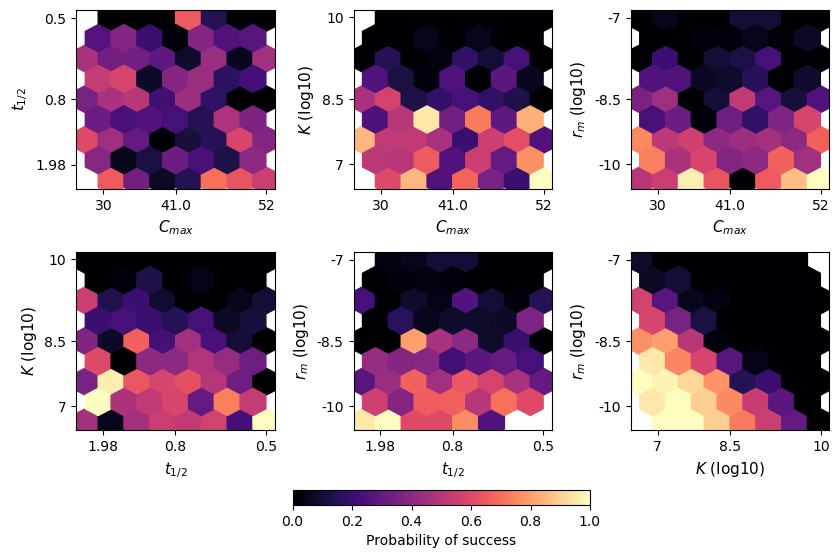

In [26]:
fig,ax_list = plt.subplots(ncols=3,nrows=2,figsize=(8.5,5))

# cmax, kelim, carrying capacity, mutation rate

cmap = 'magma'

ax = ax_list[0,0]

# ax.scatter(sample_raw[:,0],sample_raw[:,1],c=res/n_sims)
ax.hexbin(sample_raw[:,0],sample_raw[:,1],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$C_{max}$',fontsize=11)
ax.set_ylabel('$t_{1/2}$',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_yticks([0.1,0.5,1])
thalf = np.array([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
thalf = np.round(-np.log(0.5)/thalf,2)
# ax.set_yticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_yticklabels(thalf)

ax = ax_list[0,1]

# ax.scatter(sample_raw[:,0],sample_raw[:,2],c=res/n_sims)
ax.hexbin(sample_raw[:,0],sample_raw[:,2],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$C_{max}$',fontsize=11)
ax.set_ylabel('$K$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax = ax_list[0,2]

# ax.scatter(sample_raw[:,0],sample_raw[:,3],c=res/n_sims)
ax.hexbin(sample_raw[:,0],sample_raw[:,3],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$C_{max}$',fontsize=11)
ax.set_ylabel('$r_{m}$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

ax = ax_list[1,0]

# ax.scatter(sample_raw[:,1],sample_raw[:,2],c=res/n_sims)
ax.hexbin(sample_raw[:,1],sample_raw[:,2],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$t_{1/2}$',fontsize=11)
ax.set_ylabel('$K$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
# ax.set_xticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_xticklabels(thalf)

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax = ax_list[1,1]

# ax.scatter(sample_raw[:,1],sample_raw[:,3],c=res/n_sims)
ax.hexbin(sample_raw[:,1],sample_raw[:,3],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$t_{1/2}$',fontsize=11)
ax.set_ylabel('$r_{m}$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
# ax.set_xticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_xticklabels(thalf)

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

ax = ax_list[1,2]

# ax.scatter(sample_raw[:,2],sample_raw[:,3],c=res/n_sims)
hb = ax.hexbin(sample_raw[:,2],sample_raw[:,3],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$K$ (log10)',fontsize=11)
ax.set_ylabel('$r_{m}$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

cax = fig.add_axes([0.35,-0.02,0.35,0.03])

cb = fig.colorbar(hb,orientation='horizontal',cax=cax)
cb.set_label('Probability of success')

# ax_list[0,0].annotate('A',xy=(-0.2,1.1),xycoords='axes fraction',fontsize=12)
fig.tight_layout()

fig.savefig('../figures/pharmacokinetics_joint_distribution.pdf',bbox_inches='tight')

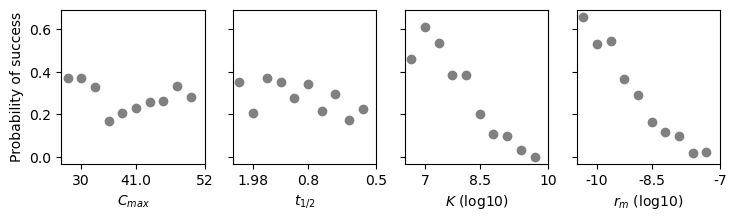

In [20]:
# plot marginal distributions for each parameter

fig,ax_list = plt.subplots(ncols=4,nrows=1,figsize=(8.5,2),sharex=False,sharey=True)

# generate bins

bins = np.linspace(0,0.9,10)

cmax_marg = []
kelim_marg = []
carry_marg = []
mut_marg = []

rate = res/n_sims

for bin in bins:
    indx = (sample_raw[:,0] > bin) & (sample_raw[:,0] <= bin + 0.1)
    cmax_marg.append(np.mean(rate[indx]))

    indx = (sample_raw[:,1] > bin) & (sample_raw[:,1] <= bin + 0.1)
    kelim_marg.append(np.mean(rate[indx]))

    indx = (sample_raw[:,2] > bin) & (sample_raw[:,2] <= bin + 0.1)
    carry_marg.append(np.mean(rate[indx]))

    indx = (sample_raw[:,3] > bin) & (sample_raw[:,3] <= bin + 0.1)
    mut_marg.append(np.mean(rate[indx]))

ax = ax_list[0]
ax.scatter(bins,cmax_marg,color='gray')

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_xlabel('$C_{max}$')

ax = ax_list[1]

ax.scatter(bins,kelim_marg,color='gray')

ax.set_xticks([0.1,0.5,1])
# ax.set_xticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_xticklabels(thalf)

ax.set_xlabel('$t_{1/2}$')

ax = ax_list[2]

ax.scatter(bins,carry_marg,color='gray')

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax.set_xlabel('$K$ (log10)')  

ax = ax_list[3]

ax.scatter(bins,mut_marg,color='gray')

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

ax.set_xlabel('$r_{m}$ (log10)')

ax_list[0].set_ylabel('Probability of success')

# ax_list[0].annotate('B',xy=(-0.3,1.1),xycoords='axes fraction',fontsize=12);

fig.savefig('../figures/pharmacokinetics_marginal_distributions.pdf',bbox_inches='tight')

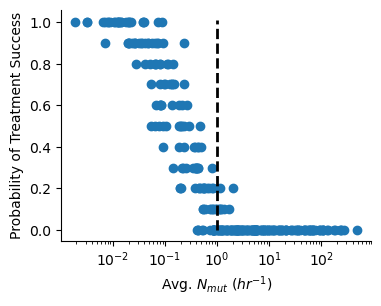

In [15]:
indx = (res/n_sims > 0.3) & (res/n_sims < 0.7)

fig,ax = plt.subplots(figsize=(4,3))

ax.plot(sample[:,2]*sample[:,3],res/n_sims,'o')

ax.plot([1,1],[0,1.01],'--',color='k',linewidth=2)

ax.set_xscale('log')

ax.set_xlabel('Avg. $N_{mut}$ ($hr^{-1}$)')

ax.set_ylabel('Probability of Treatment Success')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../figures/mutation_supply.pdf',bbox_inches='tight')

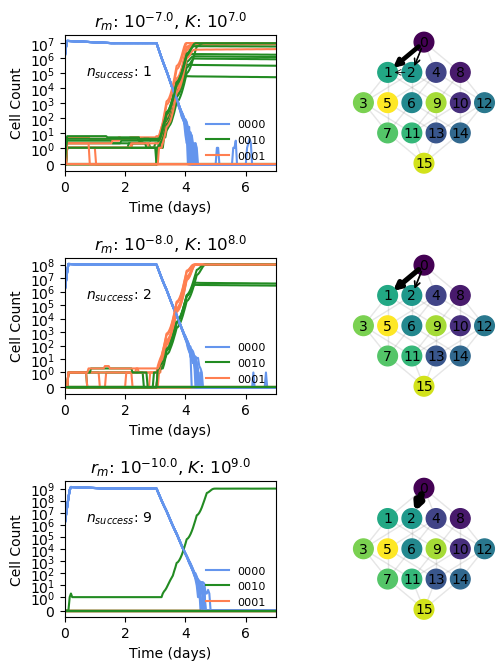

In [16]:
# trajectory analysis

np.random.seed(2024)

arrowprops = dict(arrowstyle='->', color='black', lw=1,mutation_scale=10,shrinkA=5,shrinkB=5)

landscape_options = {'node_size':200,
                    'square':True,'node_label':'base10','arrowprops':arrowprops,
                    'resize_param':0.01,'edge_alpha':0.1,'textsize':10}

params = [(10**-7,10**7),(10**-8,10**8),(10**-10,10**9)]

fig,ax_list = plt.subplots(ncols=2,nrows=3,figsize=(6,6))

time = np.arange(p.n_timestep)/24

for i,param in enumerate(params):

    p.mut_rate = param[0]
    p.carrying_cap = param[1]

    p.k_elim = -np.log(0.5)/1.5
    p.max_dose = 40

    p.reset_drug_conc_curve()

    p.drug_curve = p.max_dose*(p.drug_curve/np.max(p.drug_curve))

    ax = ax_list[i,0]

    traj_list = []
    
    n_success = 0

    # for sim_num in range(2):
    for sim_num in range(10):

        counts,et = p.simulate()
        trajectory = [0]
        for t in range(len(counts[:,0])):
            pop = counts[t,:]
            max_gen = np.argmax(pop)
            if max_gen != trajectory[-1]:
                trajectory.append(max_gen)

        if len(trajectory) > 1:
            traj_list.append(trajectory)

        if np.sum(counts,axis=1)[-1] < 1:
            n_success += 1

        ax.plot(time,counts[:,0],color='cornflowerblue',label='0000')
        ax.plot(time,counts[:,1],color='coral',label='0001')
        ax.plot(time,counts[:,2],color='forestgreen',label='0010')

    ax.set_xlim(0,7)

    ax.set_yscale('symlog',linthresh=1)

    ax.set_title('$r_{m}$: $10^{%s}$, $K$: $10^{%s}$' % (np.log10(param[0]),np.log10(param[1])))

    ax.annotate('$n_{success}$: %s' % n_success,xy=(0.1,0.7),xycoords='axes fraction')

    handles,labels = ax.get_legend_handles_labels()
    unique_labels = list(set(labels))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    ax.legend(unique_handles,unique_labels,frameon=False,loc='lower right',fontsize=8)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cell Count')

    traj_list = [tuple(traj) for traj in traj_list]

    traj_list_unique = list(set([tuple(traj) for traj in traj_list]))  

    traj_list_count = np.zeros((len(traj_list_unique)))

    for j,traj in enumerate(traj_list_unique):
        traj_list_count[j] = traj_list.count(traj)

    traj_list_count = 5*(np.array(traj_list_count)/np.sum(traj_list_count))

    traj_list_count[traj_list_count < 0.5] = 0.5

    ax = ax_list[i,1]

    plotter.plot_landscape(p,trajectory_list=traj_list_unique,conc=np.mean(p.drug_curve),
                            colorbar=False,weight_list=traj_list_count,**landscape_options,ax=ax)

# move rows 2 and 3 down
    
for i in range(2):
    for j in range(2):
        pos = ax_list[i+1,j].get_position()
        ax_list[i+1,j].set_position([pos.x0,pos.y0-0.1*(i+1),pos.width,pos.height])



fig.savefig('../figures/pharmacokinetics_trajectories.pdf',bbox_inches='tight')

# fig.tight_layout()